In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import numpy as np
from PIL import Image
import glob
import json
from matplotlib import pyplot as plt
import os
from composite_coco import *
from tqdm import tqdm
import cv2
import albumentations as A
import pandas as pd
import random

import shutil
from sahi.utils.file import load_json, save_json
from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation, merge_from_list
from sahi.utils.cv import get_coco_segmentation_from_bool_mask, get_bbox_from_bool_mask
from sklearn.model_selection import GroupKFold

/home/azureuser/miniconda/envs/pt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# load image path as well as annotations based on which we want to generate more synthetic defect
image_path = "./Datasets/Console/train/"
annFile = "./Datasets/Console/train/_annotations.coco.json"
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# Next we will use syntehtic defect generation pipeline to augment the TRAINING set (notice here we didn't aim for
# augmenting a single category of defects but all defects)

In [ ]:
work_dir = './Augment_result_collision_on_edge_exact_aug5defects/'+'Console/'
output_defect_source_dir = work_dir +'training_defect_sources/'
# prepare defects and save in the "output_defect_source_dir" (the defect annotation file is saved as 'output_defect_source_dir/training_defect_library_annotations.json')
defect_source_prep(image_path, coco, output_defect_source_dir)

In [6]:
# augment defects from "output_defect_source_dir" and save as "augmented_defect_dir"
defects_path = output_defect_source_dir
defect_annotation_file = output_defect_source_dir+'training_defect_library_annotations.json'
augmented_defect_dir = work_dir +'augmented_defect_library/'
augment_cat = []# ['Fiber','Tear','Surface Damage'] # the category of defect that we want to augment, here, we augment collision only, if you want to augment multiple classes of defect, an example is  ['Collision','scratch']
augment_cat_Ids = coco.getCatIds(catNms=augment_cat) # get catIdes
augment(defects_path, defect_annotation_file, augmented_defect_dir, augment_cat_Ids)

augmenting_defect_images:   0%|          | 0/120 [00:00<?, ?it/s]/home/azureuser/algos/Synthetic_image_generation/Syn copy/composite_coco.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  segmentation = np.array([np.array(poly) for poly in segs_after_transform])# this has to be a list of arrays, each array is an annotation
augmenting_defect_images: 100%|██████████| 120/120 [1:11:40<00:00, 35.84s/it]


In [7]:
# generate new dataset
# defects
work_dir = './Augment_result_collision_on_edge_exact_aug5defects/'+'Console/'
augmented_defect_dir = work_dir +'augmented_defect_library/'
defects_path = augmented_defect_dir
# defect_annotations 
defect_annotation_file = defects_path+'augmented_training_defect_library_annotations.json'
output_path = work_dir+'augmented_training_set/'
coco_bkg = coco #annotations for input background images

generate_new_dataset(image_path, coco, defects_path, defect_annotation_file, output_path,  num_def_per_img = 5, agument_per_image = 10)

Generating_synthetic_defect_image_dataset:  73%|███████▎  | 69/95 [8:26:46<3:03:23, 423.21s/it] 

In [ ]:
# sanity check

In [5]:
# load image path as well as annotations based on which we want to generate more synthetic defect
work_dir = './Augment_result_collision_on_edge_exact_aug5defects/'+'Console/'
output_path =  work_dir +'augmented_defect_library/'
defect_annotation_file = output_path + 'augmented_training_defect_library_annotations.json'

image_path = output_path
annotation_file = defect_annotation_file 
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

/tmp/ipykernel_1202020/953093729.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seg1 = np.array([np.array(poly) for poly in individual_defect_annotations['segmentation']])# this has to be a list of arrays, each array is an annotation


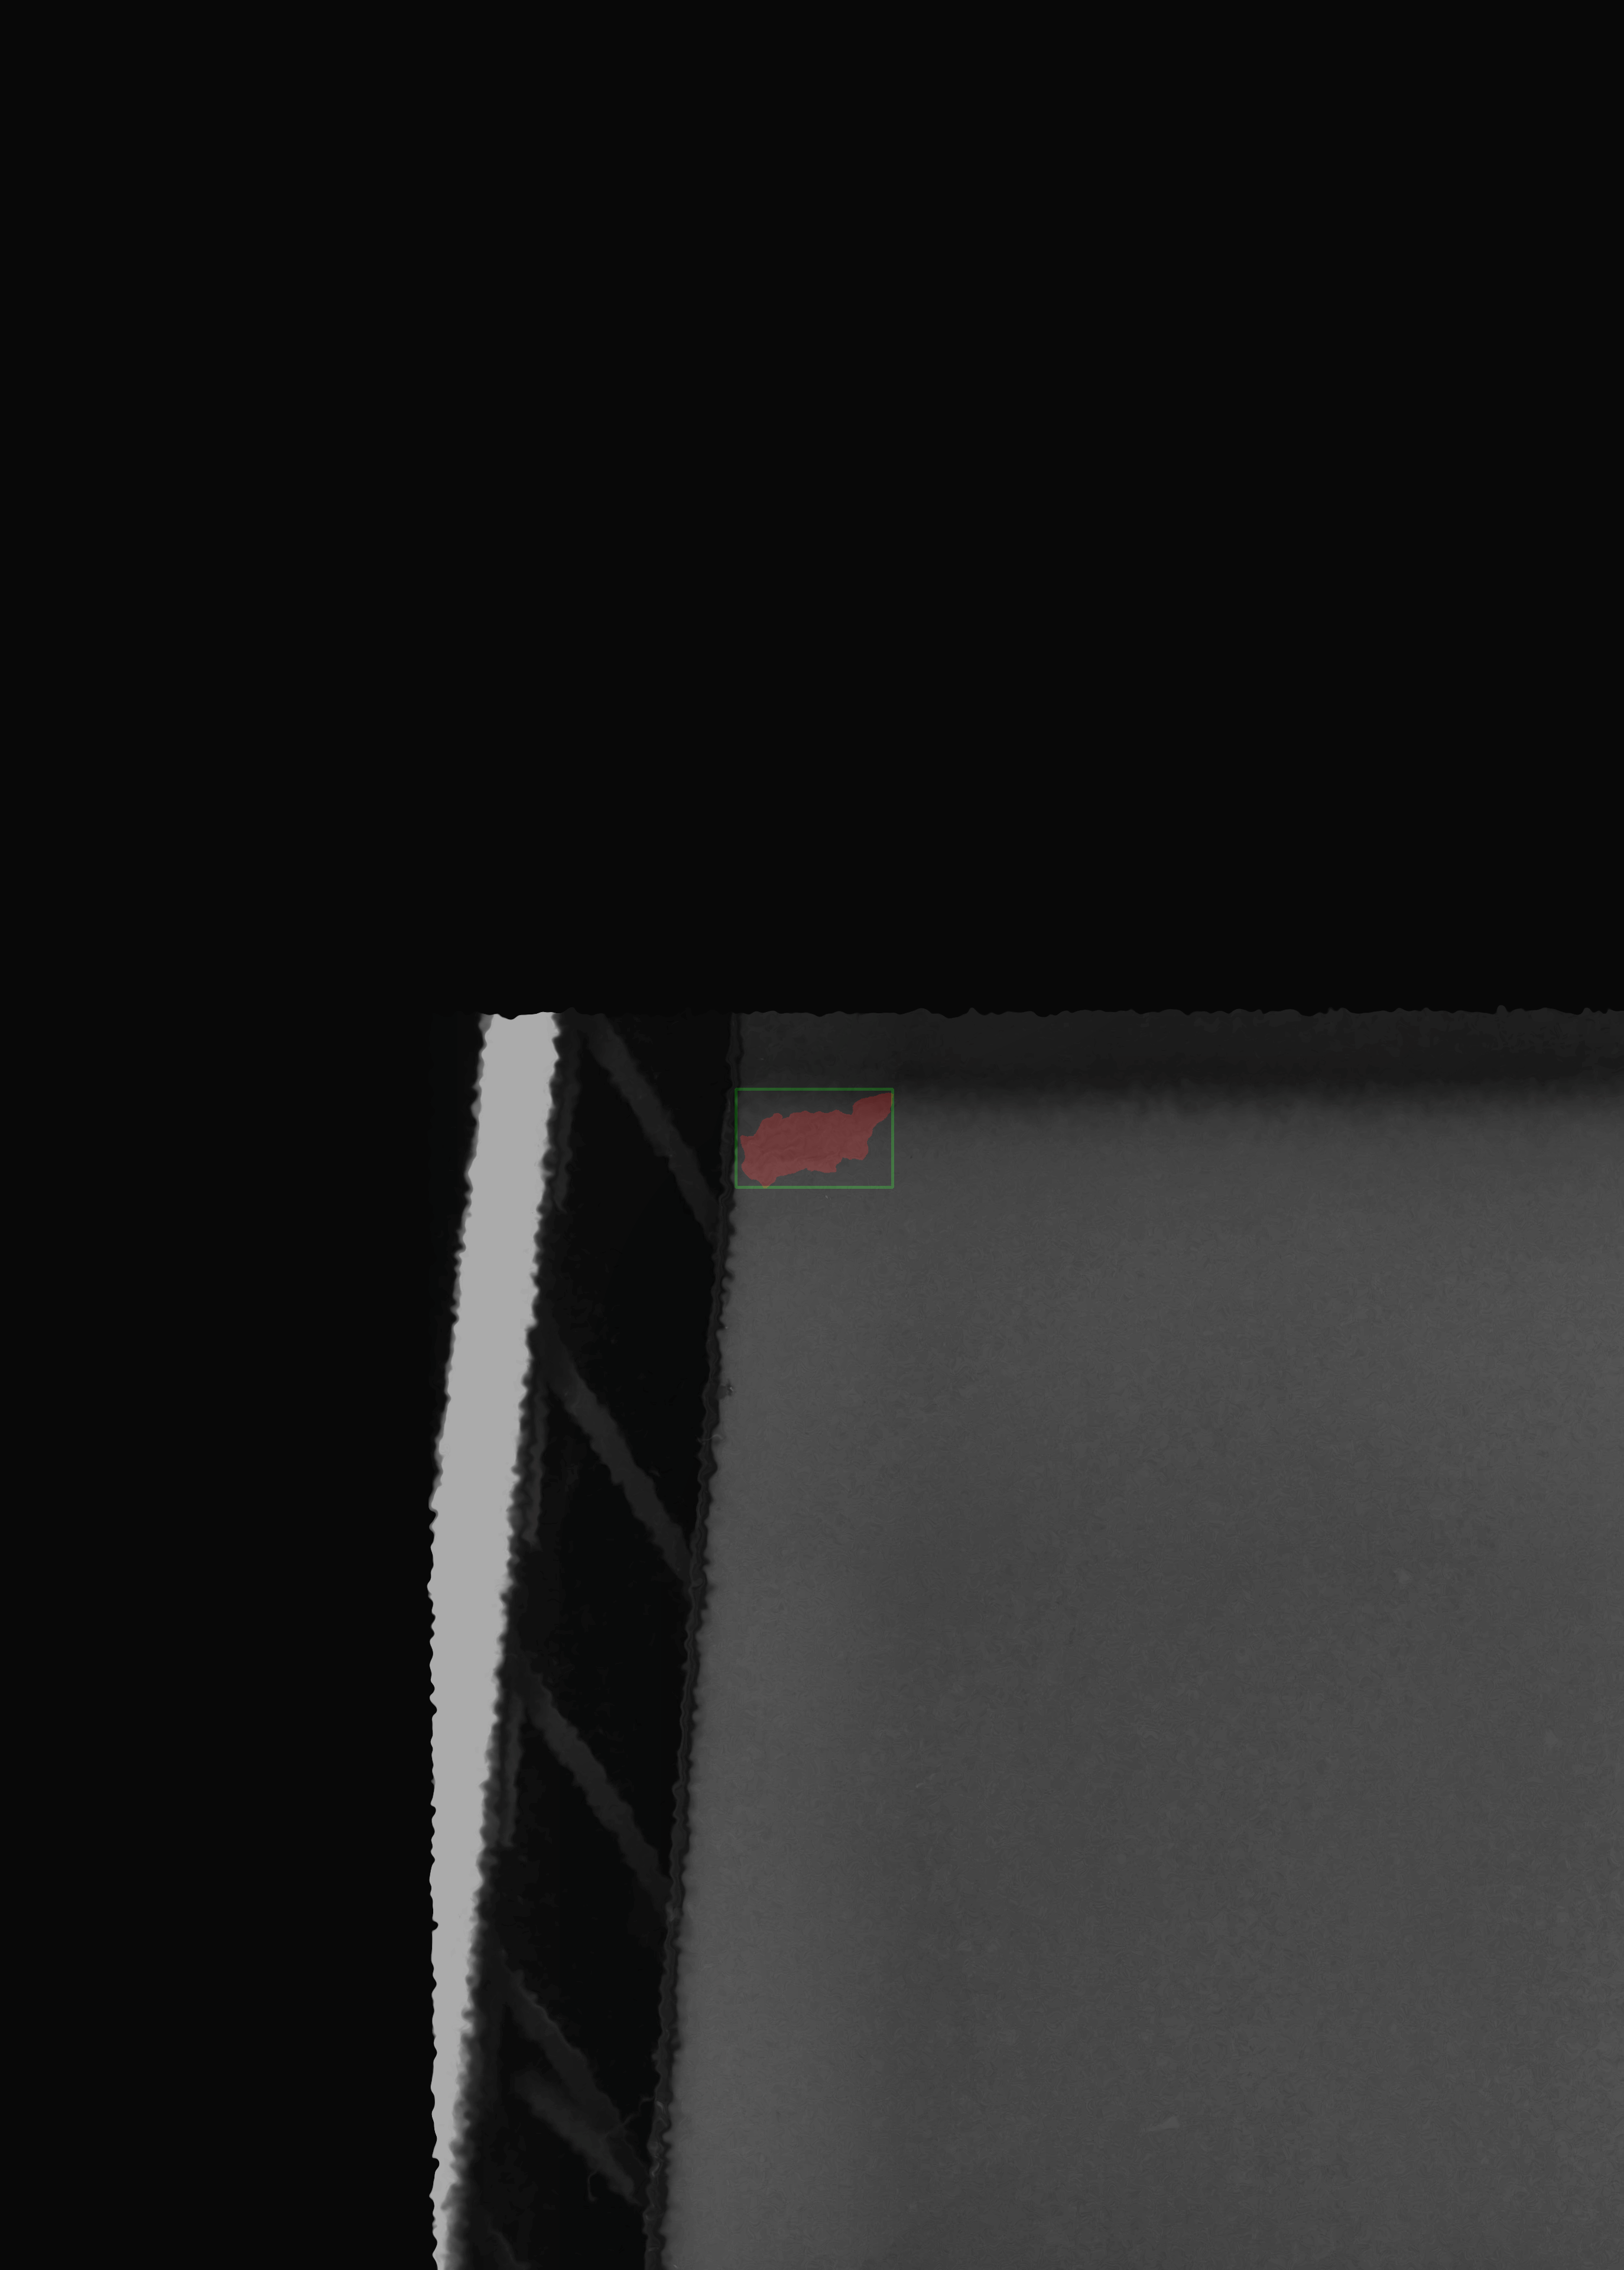

In [6]:
img_name = sorted(list(annotations.keys()))[1]
image = np.array(Image.open(os.path.join(image_path, img_name+'.png')).convert('RGB'))
# image: with defect (np array)
# annotation: defect annotations on this image (should be multiple, if only one should wrap with [])
# save_path: path to save the new image with annotation
mask = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
for individual_defect_annotations in annotations[img_name]:
    x, y, w, h = individual_defect_annotations['bbox']
    p1, p2 = (int(x), int(y)), (int(x+w), int(y+h))
    mask[:, :, 1] = cv2.rectangle(mask[:, :, 1].copy(), p1, p2, color=255, thickness=4)
    seg1 = np.array([np.array(poly) for poly in individual_defect_annotations['segmentation']])# this has to be a list of arrays, each array is an annotation   
    mask[:, :, 0] = cv2.fillPoly(mask[:, :, 0].copy(), seg1, 255, lineType=cv2.LINE_AA)
color_mask = Image.fromarray(mask)
overlay = Image.blend(Image.fromarray(image), color_mask, 0.2)
display(overlay)

In [8]:
# load image path as well as annotations based on which we want to generate more synthetic defect
work_dir = './Augment_result_collision_on_edge_exact_aug5defects/'+'Console/'
output_path = work_dir+'augmented_training_set/'
defect_annotation_file = output_path + 'generated_training_images_annotation.json'

image_path = output_path
annotation_file = defect_annotation_file 
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [9]:
img_name = sorted(list(annotations.keys()))[0]
image = np.array(Image.open(os.path.join(image_path, img_name)).convert('RGB'))

In [10]:
# img_name = '9'+img_name[1:]
# image = np.array(Image.open(os.path.join(image_path, img_name)).convert('RGB'))

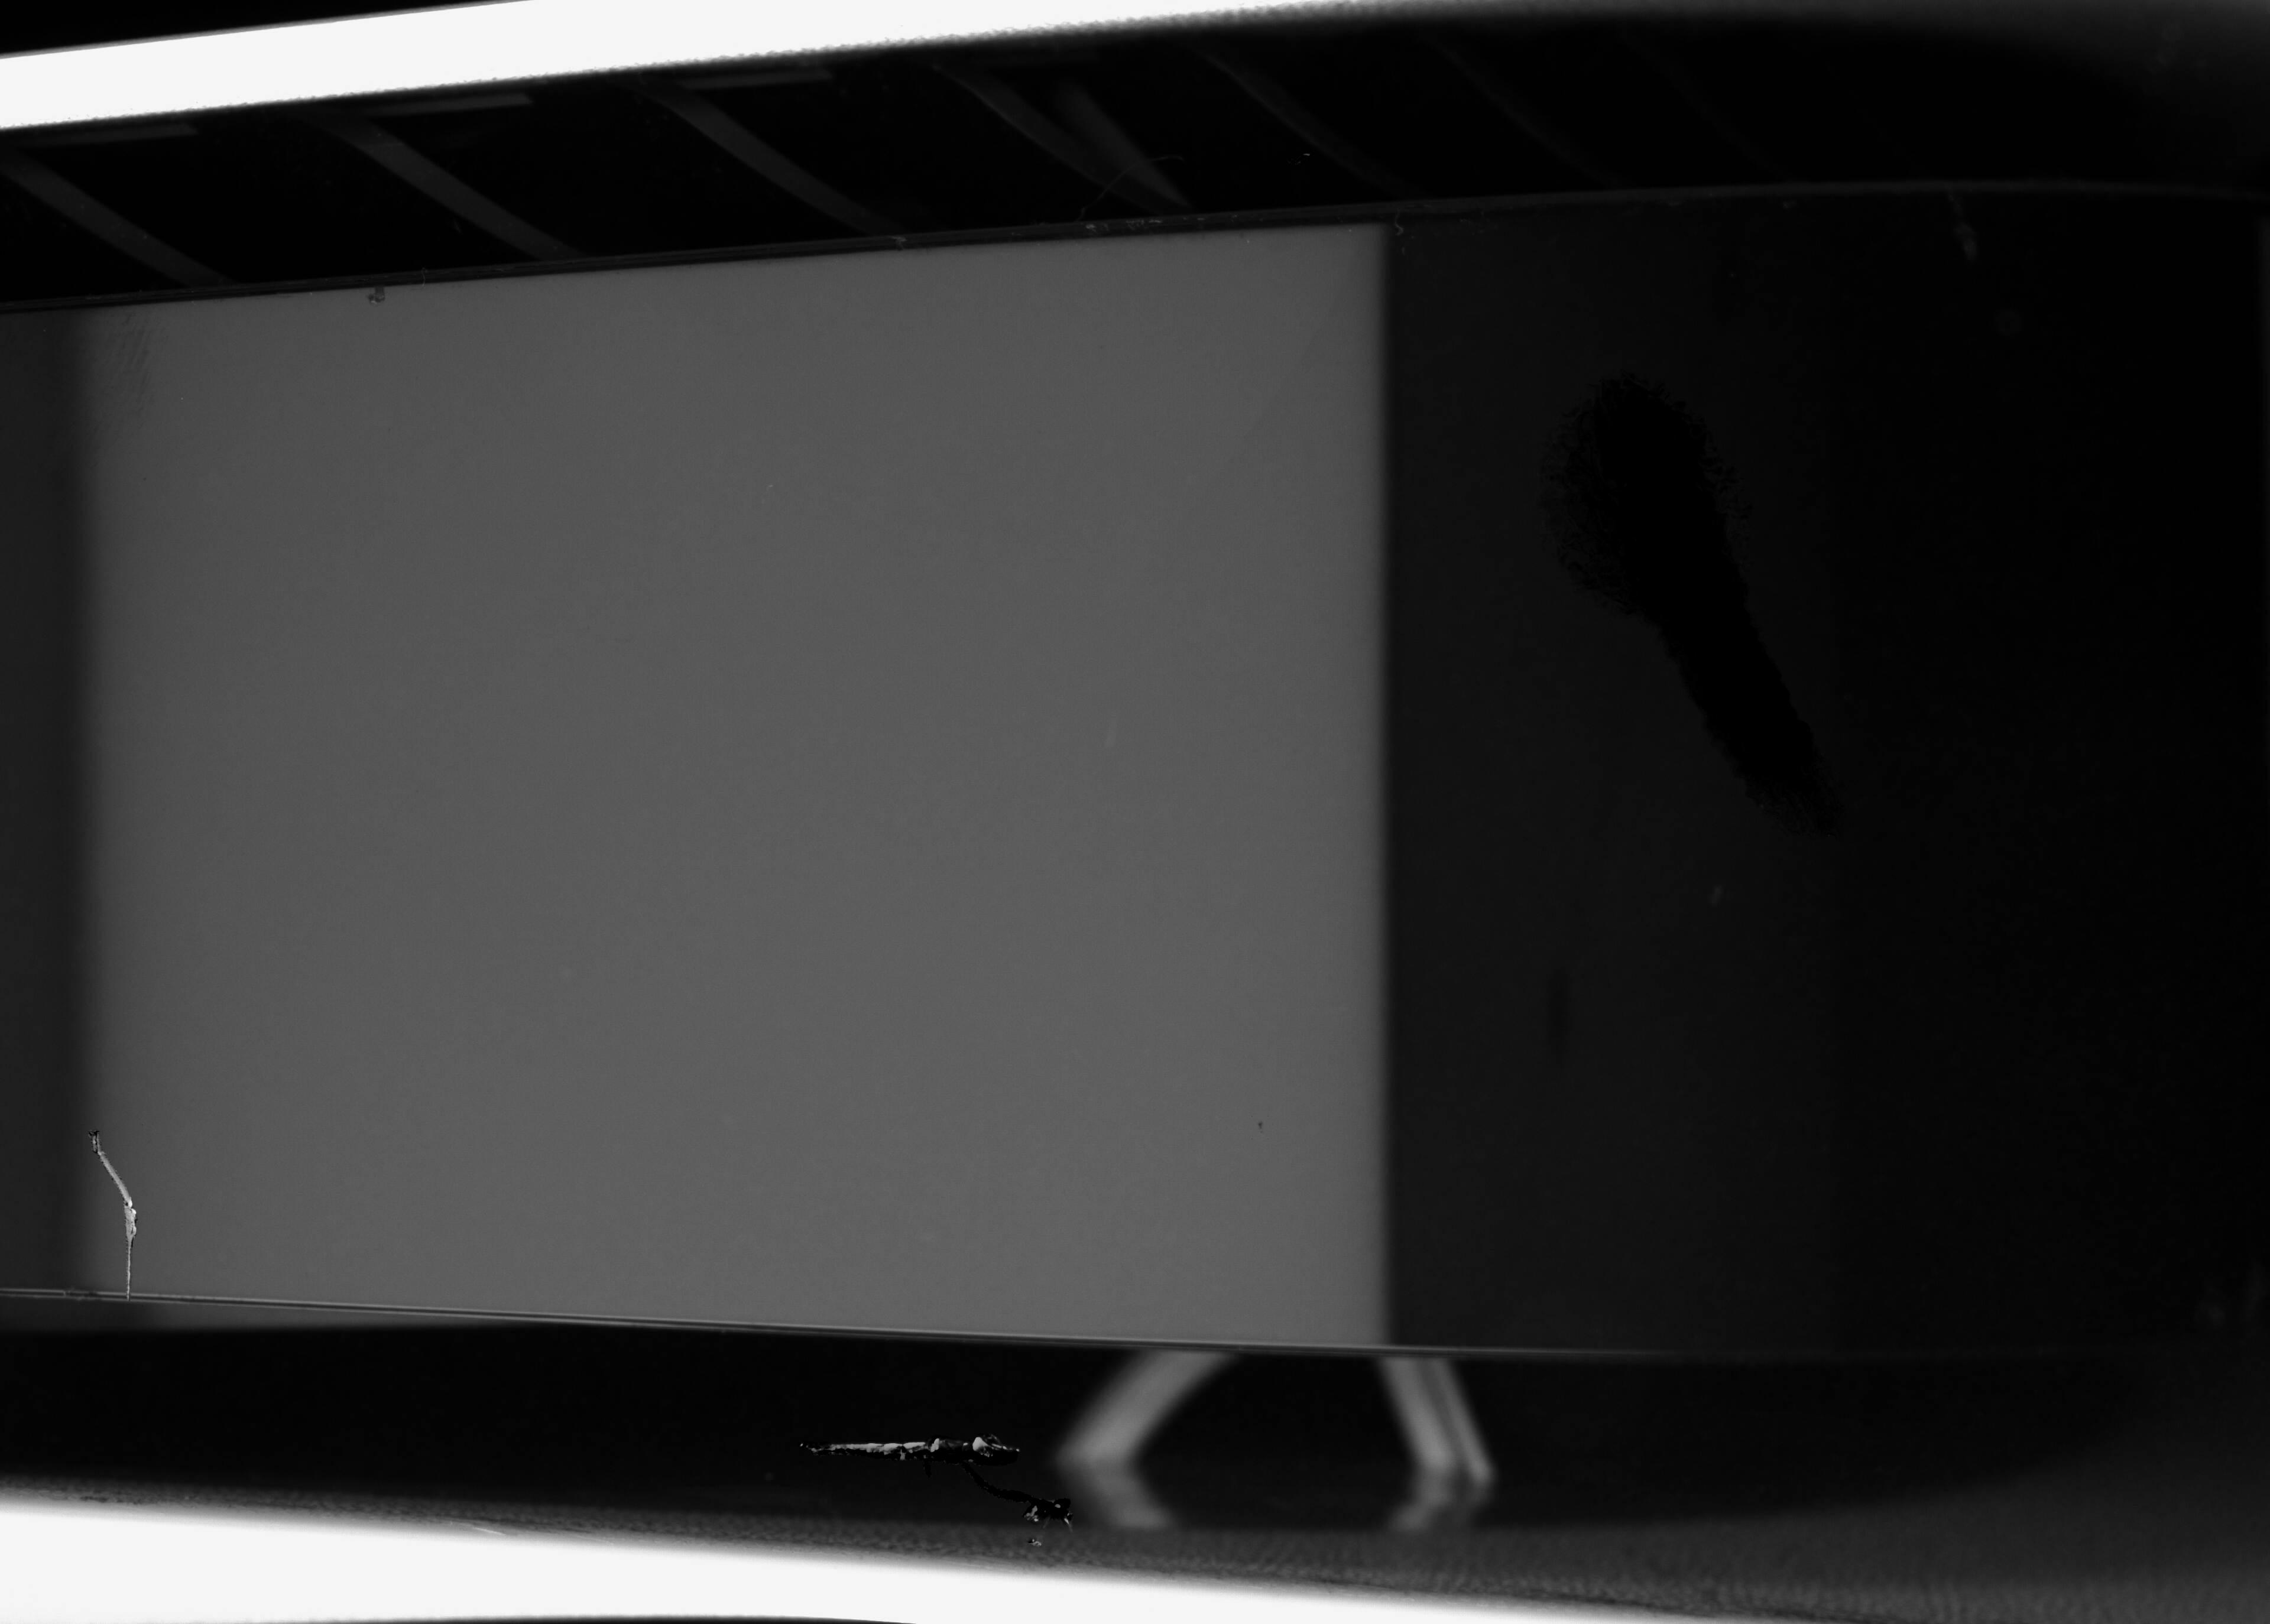

In [11]:
display(Image.open(os.path.join(image_path, img_name)).convert('RGB'))

/tmp/ipykernel_1202020/2112513215.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seg1 = np.array([np.array(poly) for poly in individual_defect_annotations['segmentation']])# this has to be a list of arrays, each array is an annotation


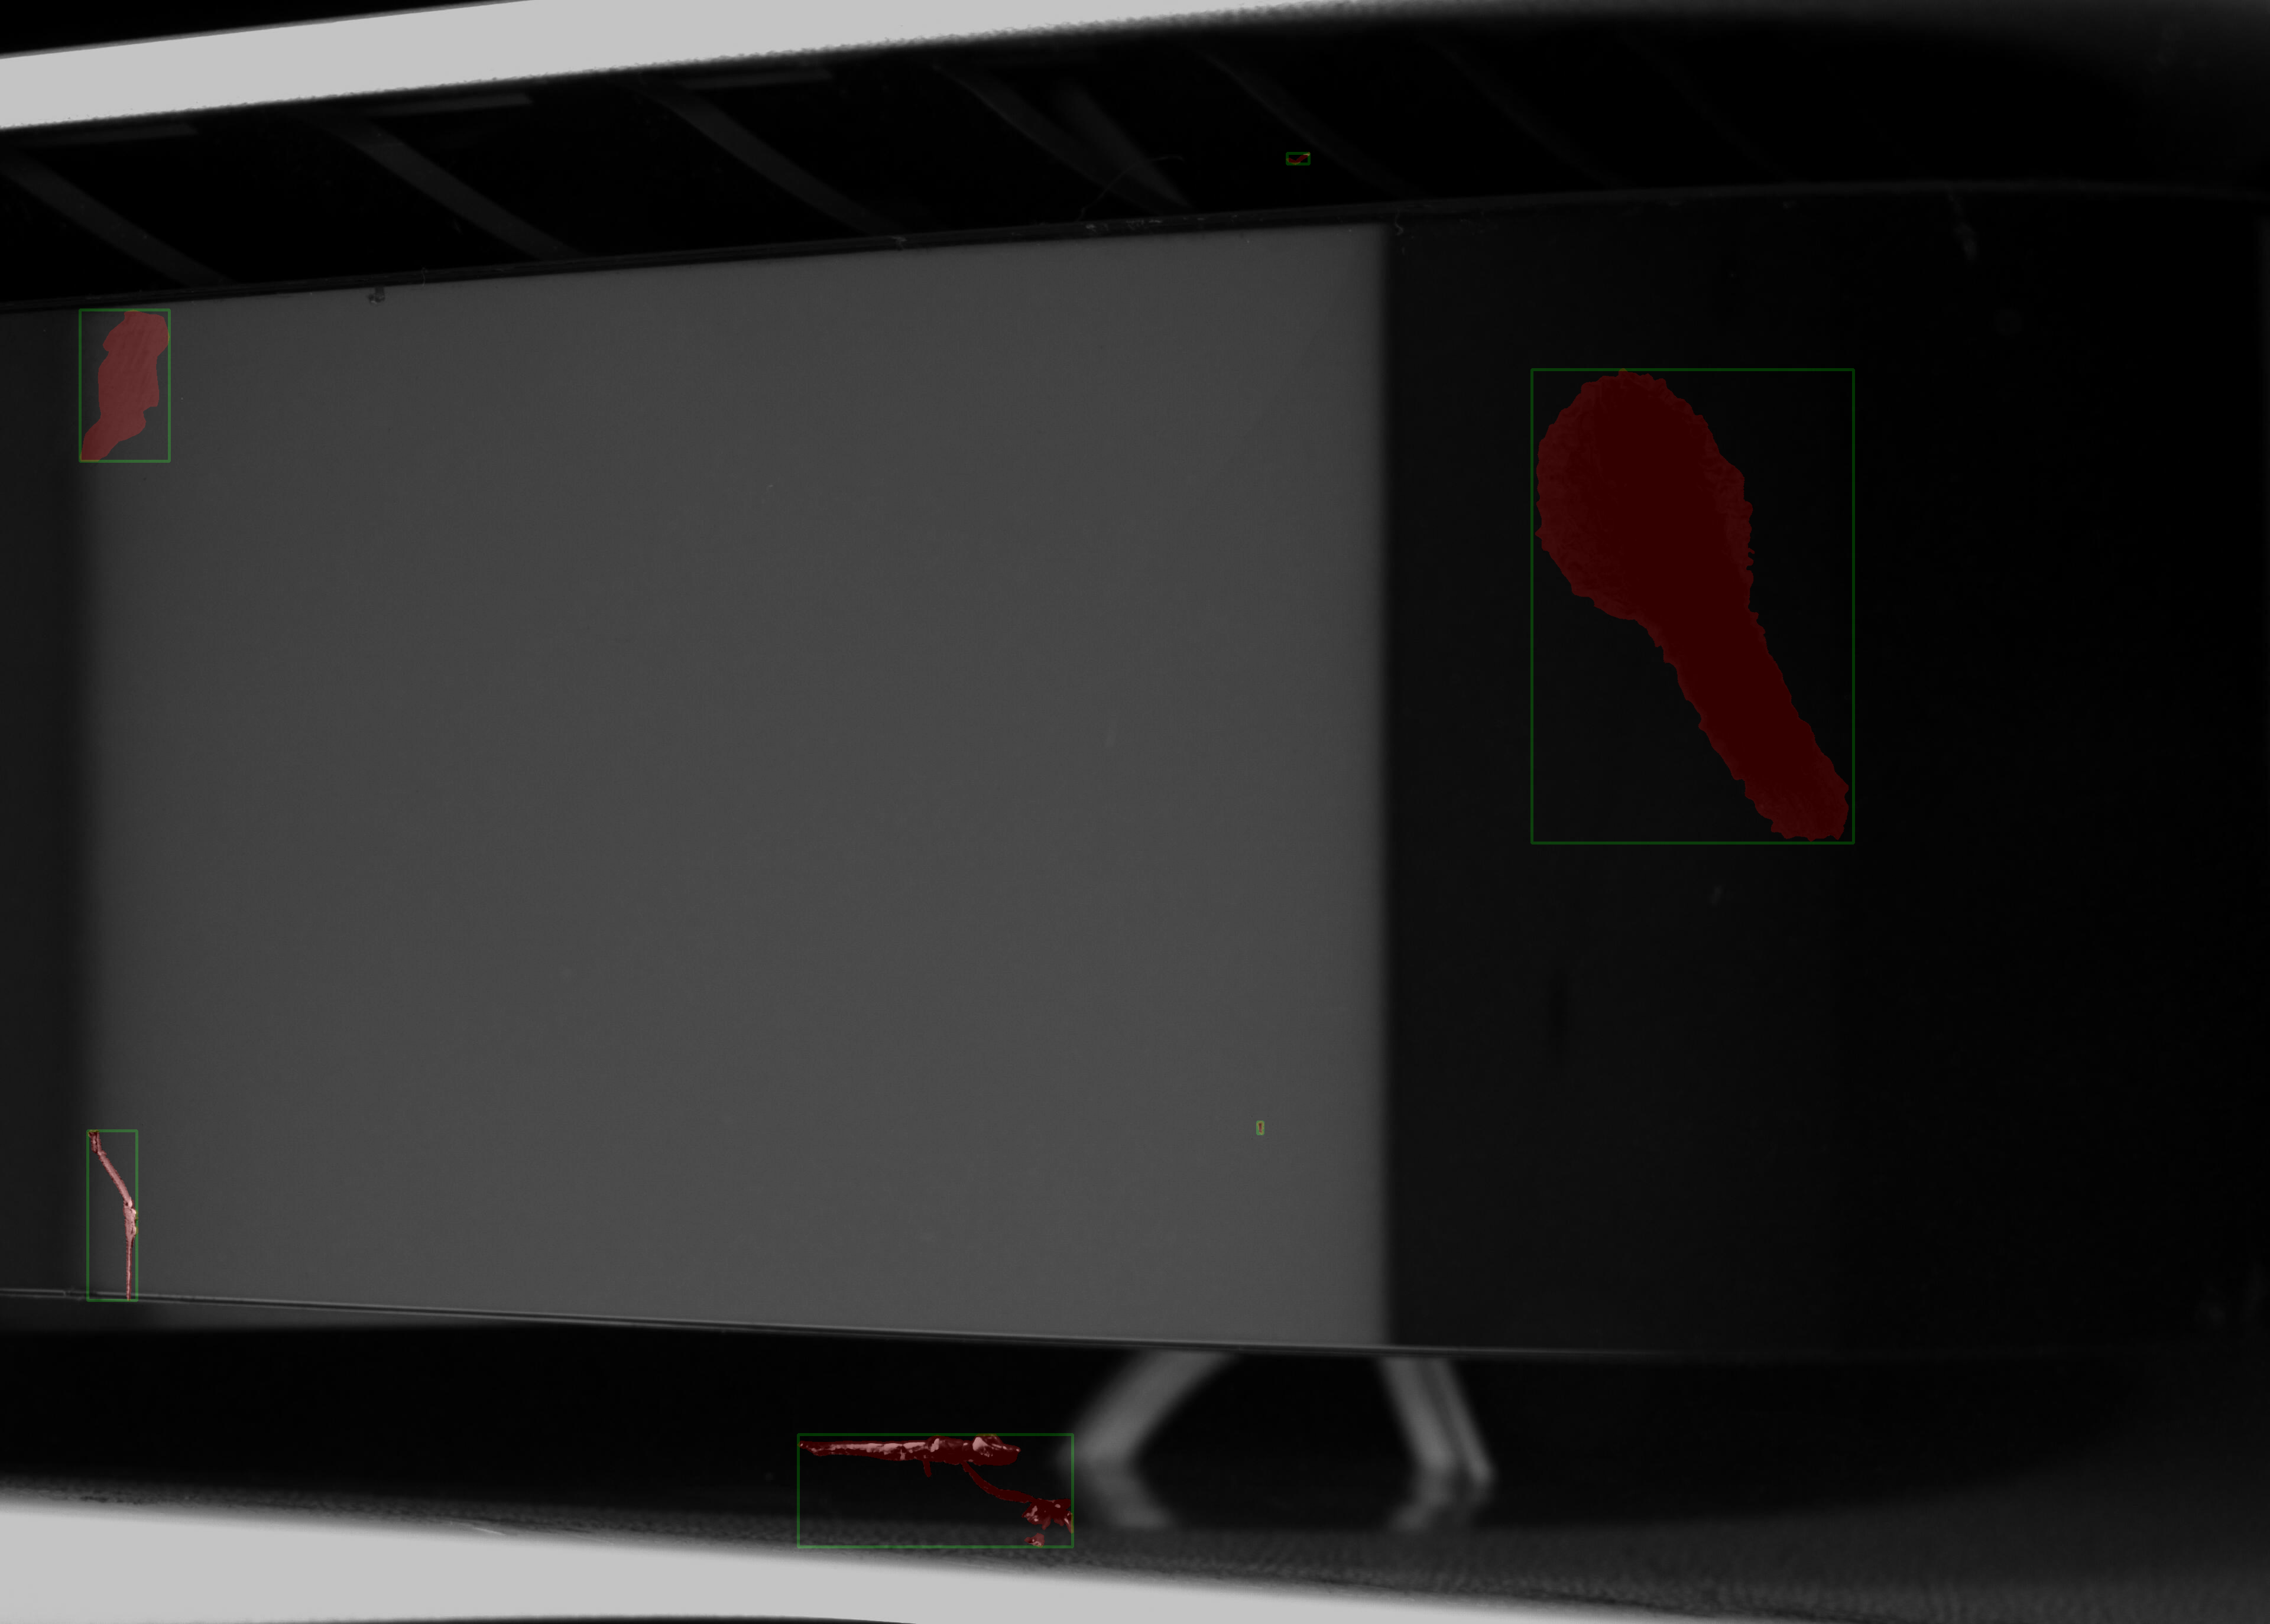

In [12]:
# image: with defect (np array)
# annotation: defect annotations on this image (should be multiple, if only one should wrap with [])
# save_path: path to save the new image with annotation
mask = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
for individual_defect_annotations in annotations[img_name]:
    x, y, w, h = individual_defect_annotations['bbox']
    p1, p2 = (int(x), int(y)), (int(x+w), int(y+h))
    mask[:, :, 1] = cv2.rectangle(mask[:, :, 1].copy(), p1, p2, color=255, thickness=4)
    seg1 = np.array([np.array(poly) for poly in individual_defect_annotations['segmentation']])# this has to be a list of arrays, each array is an annotation   
    mask[:, :, 0] = cv2.fillPoly(mask[:, :, 0].copy(), seg1, 255, lineType=cv2.LINE_AA)
color_mask = Image.fromarray(mask)
overlay = Image.blend(Image.fromarray(image), color_mask, 0.2)
display(overlay)

In [13]:
# change 'augmented_training_defect_library_annotations.json' to coco format

In [14]:
# generate a dataframe that matches 
# nms=[cat['name'] for cat in cats]
cats = coco.loadCats(coco.getCatIds())
cat_id = {}
for defect_type in cats:
    cat_id[defect_type['id']] = defect_type['name']
rows = []
defect_id = 0
images = sorted(list(annotations.keys()))
for image_id, image_name in enumerate(images):
    image = Image.open(os.path.join(image_path, image_name)).convert('RGB')
    defects = annotations[image_name]
    for defect in defects:
        mask = np.zeros((image.height, image.width)).astype(np.uint8)
        seg1 = [np.array(poly) for poly in defect['segmentation']]
        mask = cv2.fillPoly(mask, seg1, 255, lineType=cv2.LINE_AA)
        rows.append({
            'defect_id': defect_id,
            'image_id': image_id,
            'image_name':image_name, # I added a image name
            'category': cat_id[defect['category_id']],
            'category_id': defect['category_id'],
            'bbox': get_bbox_from_bool_mask(mask),
            'seg': get_coco_segmentation_from_bool_mask(mask),
        })
df = pd.DataFrame(rows)

In [15]:
train_imgs = sorted(list(annotations.keys()))
val_imges = []

In [16]:
# # Generate Coco Style Annotation with Sahi
# data_path = work_dir + 'ps5_seg_coco/'
# coco_train = Coco()
# coco_valid = Coco()

# for category, i in cat_id.items():
#     coco_train.add_category(CocoCategory(id=i, name=category))
#     coco_valid.add_category(CocoCategory(id=i, name=category))

# for image_id, image_name in enumerate(images):
#     image = Image.open(os.path.join(image_path, image_name)).convert('RGB')
#     coco_image = CocoImage(file_name=image_name, height=image.height, width=image.width)

#     defects = df[df.image_name == image_name]
#     for _, defect in defects.iterrows():
#         # print(defect.bbox, defect.seg, defect.category_id, defect.category)
#         if defect.bbox:
#             coco_image.add_annotation(
#                 CocoAnnotation(
#                     bbox=defect.bbox,
#                     segmentation=defect.seg,
#                     category_id=defect.category_id,
#                     category_name=defect.category
#                 )
#             )
#     if image_name in train_imgs:
#         shutil.copy(os.path.join(image_path, image_name), os.path.join(data_path, 'train', image_name))
#         coco_train.add_image(coco_image)
# print(coco_train.stats["num_annotations_per_category"])
# save_json(coco_train.json, os.path.join(data_path, 'train', '_annotations.coco.json'))


In [17]:
# Generate Coco Style Annotation with Sahi
binarize = False
data_path = work_dir + 'Lense_seg_coco_original_images/'
os.makedirs(data_path, exist_ok = True)
coco_train = Coco()
coco_valid = Coco()

if binarize:
    coco_train.add_category(CocoCategory(id=0, name='NG'))
    coco_valid.add_category(CocoCategory(id=0, name='NG'))
else:
    for i, category in cat_id.items():
        coco_train.add_category(CocoCategory(id=i, name=category))
        coco_valid.add_category(CocoCategory(id=i, name=category))

for image_id, image_name in enumerate(images):
    image = Image.open(os.path.join(image_path, image_name)).convert('RGB')
    coco_image = CocoImage(file_name=image_name, height=image.height, width=image.width)

    defects = df[df.image_name == image_name]
    for _, defect in defects.iterrows():
        # print(defect.bbox, defect.seg, defect.category_id, defect.category)
        if defect.bbox:
            coco_image.add_annotation(
                CocoAnnotation(
                    bbox=defect.bbox,
                    segmentation=defect.seg,
                    category_id=0 if binarize else defect.category_id,
                    category_name='NG' if binarize else defect.category
                )
            )
    if image_name in train_imgs:
        os.makedirs( os.path.join(data_path, 'train'), exist_ok = True)
        shutil.copy(os.path.join(image_path, image_name), os.path.join(data_path, 'train', image_name))
        coco_train.add_image(coco_image)
    # elif image_name in valid_imgs:
    #     os.makedirs( os.path.join(data_path, 'valid'), exist_ok = True)
    #     shutil.copy(os.path.join(image_path, image_name), os.path.join(data_path, 'valid', image_name))
    #     coco_valid.add_image(coco_image)
print(coco_train.stats["num_annotations_per_category"])
# print(coco_valid.stats["num_annotations_per_category"])
save_json(coco_train.json, os.path.join(data_path, 'train', '_annotations.coco.json'))
# save_json(coco_valid.json, os.path.join(data_path, 'valid', '_annotations.coco.json'))

{'Collision': 1684, 'Dirty': 1702, 'Gap': 991, 'Scratch': 1573}


In [ ]:
# Create Sliced Datasets with Sahi
from sahi.slicing import slice_coco
from sahi.utils.file import load_json, save_json


data_path = work_dir + 'Lense_seg_coco_original_images/'
slice_path = work_dir + 'Lense_sliced_by_sahi/'
train_sliced_coco_dict, _ = slice_coco(
    coco_annotation_file_path=os.path.join(data_path, 'train', '_annotations.coco.json'),
    image_dir=os.path.join(data_path, 'train'),
    output_coco_annotation_file_name=None,
    ignore_negative_samples=False,
    output_dir=os.path.join(slice_path, 'train'),
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=0.01,
    verbose=False
)
save_json(train_sliced_coco_dict, os.path.join(slice_path, 'train', '_annotations.coco.json'))


print("Done!")

In [ ]:
from pathlib import Path

slice_path = work_dir + 'Lense_sliced_by_sahi/'

from tqdm import tqdm
from sahi.utils.cv import get_bool_mask_from_coco_segmentation

custom_palette = [120, 120, 120, 180, 120, 120, 6, 230, 230, 80, 50, 50, 4, 200, 3, 120, 120, 80, 140, 140, 140, 204, 5, 255, 230, 230, 230, 4, 250, 7, 224, 5, 255, 235, 255, 7, 150, 5, 61, 120, 120, 70, 8, 255, 51, 255, 6, 82, 143, 255, 140, 204, 255, 4, 255, 51, 7, 204, 70, 3, 0, 102, 200, 61, 230, 250, 255, 6, 51, 11, 102, 255, 255, 7, 71, 255, 9, 224, 9, 7, 230, 220, 220, 220, 255, 9, 92, 112, 9, 255, 8, 255, 214, 7, 255, 224, 255, 184, 6, 10, 255, 71, 255, 41, 10, 7, 255, 255, 224, 255, 8, 102, 8, 255, 255, 61, 6, 255, 194, 7, 255, 122, 8, 0, 255, 20, 255, 8, 41, 255, 5, 153, 6, 51, 255, 235, 12, 255, 160, 150, 20, 0, 163, 255, 140, 140, 140, 250, 10, 15, 20, 255, 0, 31, 255, 0, 255, 31, 0, 255, 224, 0, 153, 255, 0, 0, 0, 255, 255, 71, 0, 0, 235, 255, 0, 173, 255, 31, 0, 255, 11, 200, 200, 255, 82, 0, 0, 255, 245, 0, 61, 255, 0, 255, 112, 0, 255, 133, 255, 0, 0, 255, 163, 0, 255, 102, 0, 194, 255, 0, 0, 143, 255, 51, 255, 0, 0, 82, 255, 0, 255, 41, 0, 255, 173, 10, 0, 255, 173, 255, 0, 0, 255, 153, 255, 92, 0, 255, 0, 255, 255, 0, 245, 255, 0, 102, 255, 173, 0, 255, 0, 20, 255, 184, 184, 0, 31, 255, 0, 255, 61, 0, 71, 255, 255, 0, 204, 0, 255, 194, 0, 255, 82, 0, 10, 255, 0, 112, 255, 51, 0, 255, 0, 194, 255, 0, 122, 255, 0, 255, 163, 255, 153, 0, 0, 255, 10, 255, 112, 0, 143, 255, 0, 82, 0, 255, 163, 255, 0, 255, 235, 0, 8, 184, 170, 133, 0, 255, 0, 255, 92, 184, 0, 255, 255, 0, 31, 0, 184, 255, 0, 214, 255, 255, 0, 112, 92, 255, 0, 0, 224, 255, 112, 224, 255, 70, 184, 160, 163, 0, 255, 153, 0, 255, 71, 255, 0, 255, 0, 163, 255, 204, 0, 255, 0, 143, 0, 255, 235, 133, 255, 0, 255, 0, 235, 245, 0, 255, 255, 0, 122, 255, 245, 0, 10, 190, 212, 214, 255, 0, 0, 204, 255, 20, 0, 255, 255, 255, 0, 0, 153, 255, 0, 41, 255, 0, 255, 204, 41, 0, 255, 41, 255, 0, 173, 0, 255, 0, 245, 255, 71, 0, 255, 122, 0, 255, 0, 255, 184, 0, 92, 255, 184, 255, 0, 0, 133, 255, 255, 214, 0, 25, 194, 194, 102, 255, 0, 92, 0, 255]

sliced_train = Coco.from_coco_dict_or_path(os.path.join(slice_path, 'train', '_annotations.coco.json'))
# sliced_valid = Coco.from_coco_dict_or_path(os.path.join(slice_path, 'valid', '_annotations.coco.json'))

seg_path = work_dir+'/Lense_sliced_by_sahi_show_mask'
Path(seg_path).mkdir(parents=True, exist_ok=True)
Path(os.path.join(seg_path, 'train')).mkdir(parents=True, exist_ok=True)
# Path(os.path.join(seg_path, 'valid')).mkdir(parents=True, exist_ok=True)

for image in tqdm(sliced_train.images):
    # create a zero mask of the same size as the image
    mask = np.zeros((image.height, image.width), dtype=np.uint8)
    for annotation in image.annotations:
        bmask = get_bool_mask_from_coco_segmentation(annotation.segmentation, image.height, image.width)
        mask[bmask > 0.] = annotation.category_id + 1
    if mask.sum() > 0:
        shutil.copy(os.path.join(slice_path, 'train', image.file_name), os.path.join(seg_path, 'train', image.file_name))
        mask = Image.fromarray(mask).convert('P')
        mask.putpalette(custom_palette)
        mask.save(os.path.join(seg_path, 'train', image.file_name.replace('.jpg', '.png')))

# for image in tqdm(sliced_valid.images):
#     # create a zero mask of the same size as the image
#     mask = np.zeros((image.height, image.width), dtype=np.uint8)
#     for annotation in image.annotations:
#         bmask = get_bool_mask_from_coco_segmentation(annotation.segmentation, image.height, image.width)
#         mask[bmask > 0.] = annotation.category_id + 1
#     if mask.sum() > 0:
#         shutil.copy(os.path.join(slice_path, 'valid', image.file_name), os.path.join(seg_path, 'valid', image.file_name))
#         mask = Image.fromarray(mask).convert('P')
#         mask.putpalette(custom_palette)
#         mask.save(os.path.join(seg_path, 'valid', image.file_name.replace('.jpg', '.png')))